# Analysis of Zenodo data

## Import of packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

## Load data

In [2]:
datasets = pd.read_csv("../zenodo_datasets.tsv", sep="\t")
print(f"Found {datasets.shape[0]} datasets.")
files = pd.read_csv("../zenodo_files.tsv", sep="\t")
print(f"Found {files.shape[0]} files.")

Found 3393 datasets.
Found 108179 files.


/home/pierre/.soft/miniconda3/envs/mdws/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
datasets = datasets.drop_duplicates(subset=["dataset_id"], keep="first")
print(datasets.shape)

(808, 14)


In [4]:
#tab = pd.merge(datasets, files, how="left", on=["dataset_id", "origin"])
tab = pd.merge(datasets, files, how="left", on="dataset_id", validate="one_to_many")

In [5]:
tab.shape

(108179, 22)

## Read query parameters

In [6]:
def read_query_file(filename):
    """File query.yml parser.

    This function parses the query file.

    Parameters
    ----------
    filename : str
        Filename for query parameters.
    
    Returns
    -------
    file_types : dict
        Dictionary with type, engine, keywords to use and category
    """
    with open(filename, "r") as param_file:
        data_loaded = yaml.safe_load(param_file)
    file_types = data_loaded["file_types"]
    return file_types

In [7]:
dico_file_types = read_query_file("../query.yml")

ext_gromacs = []
ext_namd = []
ext_amber = []

list_coordinate = []
list_trajectory = []
list_topology = []

for dico in dico_file_types:
    if dico["engine"] == "gromacs":
        ext_gromacs.append(dico["type"])
    elif dico["engine"] == "namd":
        ext_namd.append(dico["type"])
    elif dico["engine"] == "amber":
        ext_amber.append(dico["type"])
    
    if dico["category"] == "coordinate":
        list_coordinate.append(dico["type"])
    elif dico["category"] == "topology":
        list_topology.append(dico["type"])
    elif dico["category"] == "trajectory":
        list_trajectory.append(dico["type"])

ext_all = ext_gromacs + ext_namd + ext_amber
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

## Define MD engine

In [8]:
def define_md_engine(file_type):
    """Define MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "gromacs"
    elif file_type in ext_namd:
        return "namd"
    elif file_type in ext_amber:
        return "amber"
    else:
        return "none"

tab["engine_MD"] = tab["file_type"].apply(define_md_engine)

tab["engine_MD"].value_counts()

none       60237
gromacs    42092
namd        4046
amber       1804
Name: engine_MD, dtype: int64

## Define file category

In [9]:
def define_file_category(file_type):
    """Define file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

tab["category"] = tab["file_type"].apply(define_file_category)

tab["category"].value_counts()

none          60237
trajectory    27339
topology      12349
coordinate     8254
Name: category, dtype: int64

## Extract year from date

In [10]:
tab["years"] = tab["date_creation"].apply(lambda x: int(x[:4]))
datasets["years"] = datasets["date_creation"].apply(lambda x: int(x[:4]))

## Remove zip files

We remove zip files but not their content.

In [11]:
files_nb_before = tab.shape[0]
tab = tab[tab["file_type"] != "zip"]
print(f"Remove {files_nb_before - tab.shape[0]} zip files.")

Remove 779 zip files.


## Total size of all files

- in TB
- zip files excluded 

In [12]:
print(f"Total file size: {tab['file_size'].sum()/10**9:.0f} TB")

Total file size: 6858 TB


## Average number of files per dataset

In [13]:
print(f"A dataset contains on average {tab.groupby(['dataset_id'])['file_md5'].size().mean():.0f} files.")

A dataset contains on average 133 files.


## Analysis

### Number of files per MD engine

Text(0, 0.5, 'Number of files')

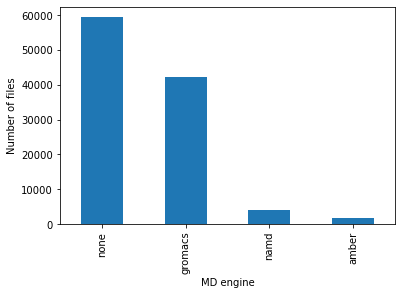

In [14]:
tab["engine_MD"].value_counts().plot(kind="bar")
plt.xlabel("MD engine")
plt.ylabel("Number of files")
# plt.savefig("Number_of_extensions_per_MDengine.png")

Text(0, 0.5, 'Number of files')

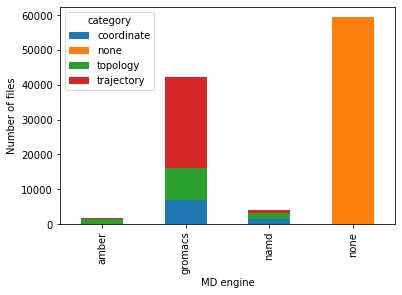

In [15]:
tab.groupby("engine_MD")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("MD engine")
plt.ylabel("Number of files")
# plt.savefig("Number_of_extensions_per_MDengine_with_categories.png")

#### Number of datasets per years

Text(0, 0.5, 'Number of datasets')

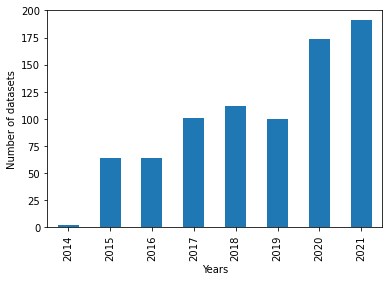

In [16]:
datasets.groupby(["years"])["dataset_id"].size().plot(kind="bar")
plt.xlabel("Years")
plt.ylabel("Number of datasets")
# plt.savefig("Number_of_datasets_per_years.png")

### Number of files per years

Text(0, 0.5, 'Number of files')

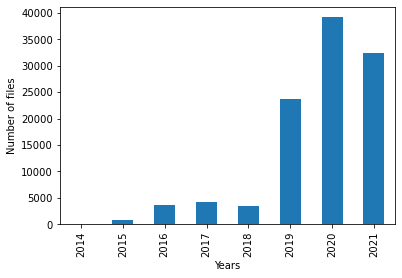

In [17]:
tab["years"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Years")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_years.png")

Text(0, 0.5, 'Number of files')

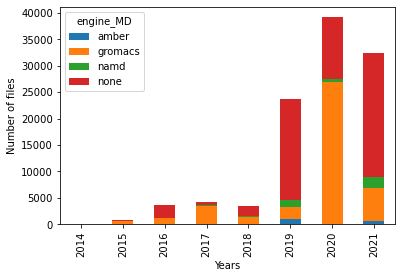

In [18]:
tab.groupby(["years", "engine_MD"]).size().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Years")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_years_with_categories.png")

Text(0, 0.5, 'Number of files')

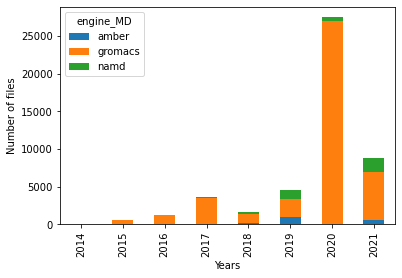

In [19]:
tab[tab["engine_MD"] != "none"].groupby(["years", "engine_MD"]).size().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Years")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_years_with_categories_without_none.png")

### Number of files per filetype

For files not associated to any MD engine.

Text(0, 0.5, 'Number of files')

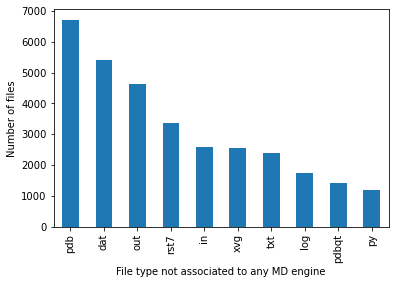

In [20]:
tab[tab["engine_MD"] == "none"]["file_type"].value_counts().head(n=10).plot(kind="bar")
plt.xlabel("File type not associated to any MD engine")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_none.png")

#### For Gromacs

Text(0, 0.5, 'Number of files')

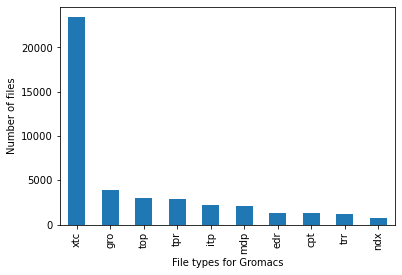

In [21]:
data_gromacs = tab[tab["file_type"].isin(ext_gromacs)]
data_gromacs["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File types for Gromacs")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_gromacs.png")

#### For Namd

Text(0, 0.5, 'Number of files')

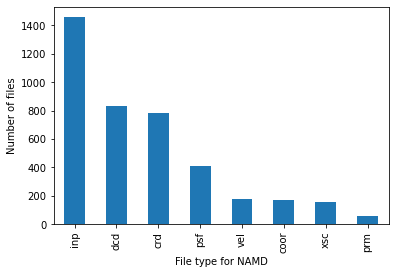

In [22]:
data_namd = tab[tab["file_type"].isin(ext_namd)]
data_namd["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File type for NAMD")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_namd.png")

#### For Amber

Text(0, 0.5, 'Number of files')

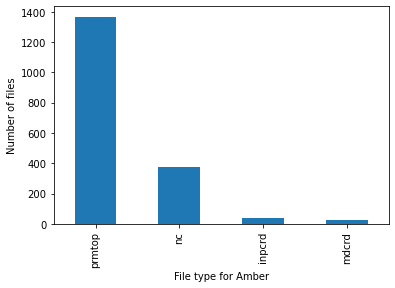

In [23]:
data_amber = tab[tab["file_type"].isin(ext_amber)]
data_amber["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File type for Amber")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_amber.png")

### File size per year

in TB

In [24]:
(tab.groupby(["years"])["file_size"].sum()/10**9)

years
2014       0.740188
2015      87.169959
2016     106.028224
2017    1209.243708
2018    1155.252567
2019    1117.974864
2020    2245.253418
2021     936.508876
Name: file_size, dtype: float64

Text(0, 0.5, 'File size (in TB)')

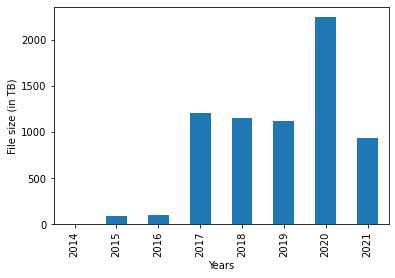

In [25]:
(tab.groupby(["years"])["file_size"].sum()/10**9).plot(kind="bar") 
plt.xlabel("Years")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_year.png")

### File size per MD engine

Text(0, 0.5, 'File size (in TB)')

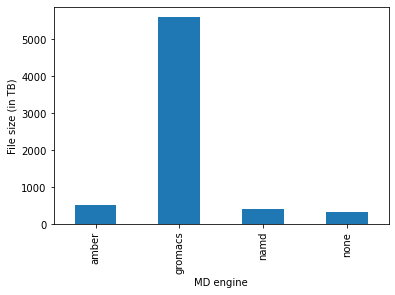

In [26]:
(tab.groupby(["engine_MD"])["file_size"].sum()/10**9).plot(kind="bar")
plt.xlabel("MD engine")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_MDengine.png")

Text(0, 0.5, 'File size (in TB)')

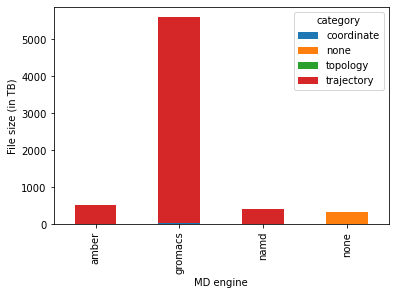

In [27]:
(tab.groupby(["engine_MD", "category"])["file_size"].sum()/10**9).unstack("category").plot(kind="bar", stacked=True)
plt.xlabel("MD engine")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_MDengine_with_categories.png")